In [34]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import combinations
from collections import Counter
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


### Sample dos dados

In [35]:
df2 = pd.read_csv("dishes_data_filtered.csv")

unknown_df = df2[df2['cuisine'] == 'Unknown']
unknown_df.to_csv("dishes_data_with_unknown_cuisine.csv", index=False)

known_df = df2[df2['cuisine'] != 'Unknown']

sample_known = known_df.sample(frac=0.17, random_state=42)
sample_unknown = unknown_df.sample(n=(len(sample_known)//2), random_state=42)

balanced_sample = pd.concat([sample_unknown, sample_known])

df = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
df.info()
df.describe()
df['cuisine'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  585 non-null    object 
 1   recipeName          585 non-null    object 
 2   rating              585 non-null    int64  
 3   totalTimeInSeconds  585 non-null    float64
 4   course              585 non-null    object 
 5   cuisine             585 non-null    object 
 6   ingredients         585 non-null    object 
 7   dish                585 non-null    object 
 8   timeMins            585 non-null    float64
 9   ingred_count        585 non-null    int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 45.8+ KB


cuisine
Unknown                 195
Asian                    81
American                 51
Barbecue                 46
Italian                  42
Spanish                  39
Mexican                  25
French                   24
Kid-Friendly             20
Cajun & Creole           19
Indian                   12
Greek                     5
Southwestern              5
Japanese                  4
Southern & Soul Food      3
Mediterranean             3
Chinese                   3
Thai                      2
Cuban                     2
Irish                     1
Hungarian                 1
Hawaiian                  1
German                    1
Name: count, dtype: int64

### Construindo a rede com NetworkX

In [37]:
G = nx.Graph()

# Adicionar nós
for _, row in df.iterrows():
    G.add_node(row['id'], cuisine=row['cuisine'], ingredients=row['ingredients'], course=row['course'], rating=row['rating'], time=row['timeMins'], ingred_count=row['ingred_count'])

# Adicionar arestas baseadas em similaridade de ingredientes
for dish1, dish2 in combinations(df['id'], 2):
    # Remover colchetes e espaços antes de dividir
    ingredients1 = set(df.loc[df['id'] == dish1, 'ingredients'].values[0].replace('[', '').replace(']', '').replace(' ', '').split(','))
    ingredients2 = set(df.loc[df['id'] == dish2, 'ingredients'].values[0].replace('[', '').replace(']', '').replace(' ', '').split(','))
    
    jaccard_sim = len(ingredients1 & ingredients2) / len(ingredients1 | ingredients2)

    # print("---------------")
    # print(dish1)
    # print(dish2)
    # print("first - ", ingredients1)
    # print("second - ", ingredients2)
    # print("intersection ", ingredients1 & ingredients2)
    # print("union ", ingredients1 | ingredients2)
    # print(jaccard_sim)
    # print(len(ingredients1 & ingredients2))

    if jaccard_sim > 0.3:  # Threshold para criar aresta
        G.add_edge(dish1, dish2, weight=jaccard_sim)
        

A similaridade de Jaccard é uma medida de similaridade entre dois conjuntos, calculada pela fórmula:
J(A,B)= 
∣A∪B∣ /
∣A∩B∣
​
onde A e B são os conjuntos de ingredientes dos pratos dish1 e dish2, respectivamente.
ingredients1 & ingredients2: Calcula a interseção dos dois conjuntos de ingredientes (ou seja, os ingredientes que ambos os pratos têm em comum).
ingredients1 | ingredients2: Calcula a união dos dois conjuntos de ingredientes (todos os ingredientes distintos de ambos os pratos).
jaccard_sim será um valor entre 0 e 1, onde valores mais altos indicam maior similaridade entre os pratos.
Criação das Arestas:

Se a similaridade de Jaccard (jaccard_sim) for maior que um threshold (no caso, 0.3), o código cria uma aresta entre os dois pratos usando G.add_edge(dish1, dish2, weight=jaccard_sim).
A aresta tem um peso que corresponde ao valor da similaridade de Jaccard.
Isso significa que dois pratos com ingredientes mais semelhantes terão uma aresta mais forte (peso maior), enquanto pratos com ingredientes diferentes terão uma aresta fraca (peso baixo).
Resultado: O grafo agora contém arestas entre os pratos que possuem uma quantidade significativa de ingredientes em comum. A força dessa relação é representada pelo peso das arestas.

In [38]:
print("Rede criada com", G.number_of_nodes(), "nós e", G.number_of_edges(), "arestas.")
print(f'Atributo dos nós (sample): {list(G.nodes(data=True))[:5]}')
print(f'Atributo das arestas (sample): {list(G.edges(data=True))[:5]}')

Rede criada com 585 nós e 110 arestas.
Atributo dos nós (sample): [('Grilled-Burgers-with-Garlicky-Arugula-1112525', {'cuisine': 'Barbecue', 'ingredients': '[arugula, garlic, extra-virgin olive oil, ground beef, whole wheat hamburger buns, cheese, fresh tomatoes]', 'course': '[Main Dishes]', 'rating': 4, 'time': 20.0, 'ingred_count': 7}), ('Pesto-Lasagna-1012456', {'cuisine': 'Italian', 'ingredients': '[pesto, butter, oven-ready lasagna noodles, grated parmesan cheese, fresh basil leaves, pinenuts, garlic, extra-virgin olive oil, grated romano cheese, kosher salt, ground black pepper, all-purpose flour, whole milk, grated nutmeg]', 'course': '[Main Dishes]', 'rating': 4, 'time': 110.0, 'ingred_count': 14}), ('Sichuan-Spiced-Dry-Brined-Turkey-1360792', {'cuisine': 'Unknown', 'ingredients': '[coriander seeds, fennel seeds, kosher salt, turkey, carrots, yellow onion, chicken stock, turkey drippings, unsalted butter, all-purpose flour, heavy cream, salt, pepper]', 'course': '[Main Dishes]'

### Visualizando a rede

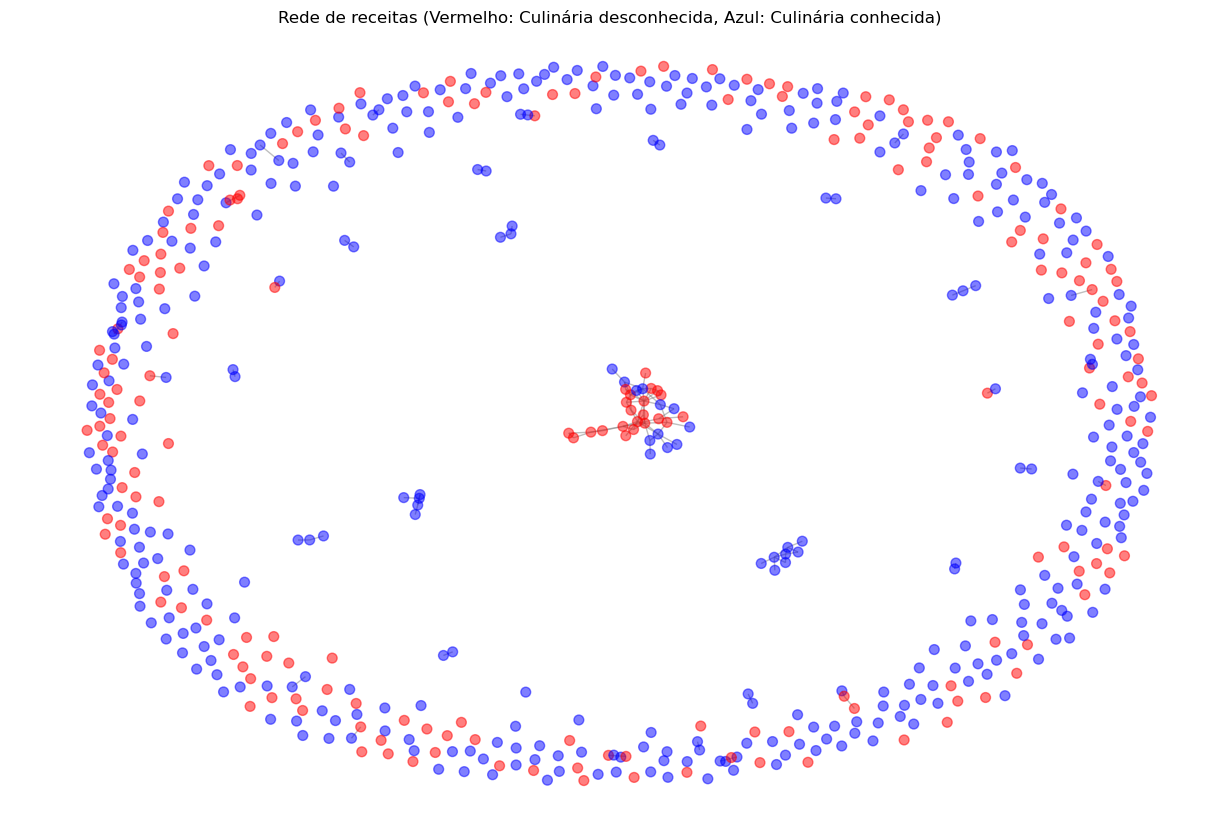

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

node_colors = ['red' if G.nodes[n]['cuisine'] == "Unknown" else 'blue' for n in G.nodes]

nx.draw(G, pos, with_labels=False, node_size=50, node_color=node_colors, edge_color='gray', alpha=0.5)

plt.title("Rede de receitas (Vermelho: Culinária desconhecida, Azul: Culinária conhecida)")
plt.show()


### Cálculo das features

In [40]:
features = []

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    if not neighbors:
        continue
    
    cuisine_counts = Counter([G.nodes[n]['cuisine'] for n in neighbors if G.nodes[n]['cuisine'] != "Unknown"])
    most_common_cuisine = cuisine_counts.most_common(1)
    likely_cuisine = most_common_cuisine[0][0] if most_common_cuisine else "Unknown"
    
    weighted_sum_rating = 0
    weighted_sum_time = 0
    weighted_sum_ingred_count = 0
    total_weight = 0

    for neighbor in neighbors:
        weight = G[node][neighbor]['weight']
        
        if pd.notna(G.nodes[neighbor]['rating']):
            weighted_sum_rating += G.nodes[neighbor]['rating'] * weight
        if pd.notna(G.nodes[neighbor]['time']):
            weighted_sum_time += G.nodes[neighbor]['time'] * weight
        if pd.notna(G.nodes[neighbor]['ingred_count']):
            weighted_sum_ingred_count += G.nodes[neighbor]['ingred_count'] * weight
        total_weight += weight

    avg_rating = weighted_sum_rating / total_weight if total_weight > 0 else 0
    avg_time = weighted_sum_time / total_weight if total_weight > 0 else 0
    avg_ingred_count = weighted_sum_ingred_count / total_weight if total_weight > 0 else 0
    num_neighbors = len(neighbors)

    # avg_rating = np.mean([G.nodes[n]['rating'] for n in neighbors if pd.notna(G.nodes[n]['rating'])])
    # avg_time = np.mean([G.nodes[n]['time'] for n in neighbors if pd.notna(G.nodes[n]['time'])])
    # avg_ingred_count = np.mean([G.nodes[n]['ingred_count'] for n in neighbors if pd.notna(G.nodes[n]['ingred_count'])])
    # num_neighbors = len(neighbors)

    clustering_coeff = nx.clustering(G, node, weight='weight')  # Coeficiente de agrupamento
    degree_centrality = nx.degree_centrality(G)[node]  # Centralidade de grau
    closeness_centrality = nx.closeness_centrality(G)[node]  # Centralidade de proximidade
    betweenness_centrality = nx.betweenness_centrality(G)[node]  # Centralidade de intermediação
    
    cuisine = G.nodes[node]['cuisine']
    features.append([node, avg_rating, avg_time, avg_ingred_count, num_neighbors, clustering_coeff, degree_centrality, closeness_centrality, betweenness_centrality, likely_cuisine, cuisine])
    # features.append([node, avg_rating, avg_time, avg_ingred_count, num_neighbors, likely_cuisine, cuisine])


In [41]:
print("Nós ignorados por não estarem conectados", (G.number_of_nodes())-len(features))

Nós ignorados por não estarem conectados 472


In [42]:
# Criar DataFrame
df_features = pd.DataFrame(features, columns=['node', 'avg_rating', 'avg_time', 'avg_ingred_count', 'num_neighbors', 'clustering_coeff', 'degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'likely_cuisine', 'cuisine'])

# Salvar o dataframe antes da previsão
df_features.to_csv("data_before_prediction.csv", index=False)

In [43]:
df_features.loc[df_features['cuisine'] == "Unknown"]

,node,avg_rating,avg_time,avg_ingred_count,num_neighbors,clustering_coeff,degree_centrality,closeness_centrality,betweenness_centrality,likely_cuisine,cuisine
2,Peach-Cobbler-1217258,4.328032,45.497018,8.656064,3,0.284568,0.005137,0.019629,0.000009,American,Unknown
4,Salmon-Roasted-In-Butter-1276969,4.000000,25.000000,11.000000,1,0.000000,0.001712,0.001712,0.000000,American,Unknown
11,Charred-Blood-Orange-Tart-1349660,4.000000,35.000000,8.000000,1,0.000000,0.001712,0.013916,0.000000,Unknown,Unknown
12,Hearty-New-England-Clam-Chowder-1234978,5.000000,45.000000,7.000000,1,0.000000,0.001712,0.001712,0.000000,American,Unknown
14,Pumpkin-Doughnut-Holes-1321314,4.116770,41.755672,9.562745,8,0.111696,0.013699,0.027422,0.000683,Kid-Friendly,Unknown
16,Pecan-Pie-1197954,4.082425,50.435506,7.934218,4,0.124400,0.006849,0.017427,0.000364,Unknown,Unknown
24,Gooey-Butter-Cake-Cookies-1371683,4.000000,55.767635,10.634855,3,0.278158,0.005137,0.019838,0.000055,French,Unknown
25,Restaurant-Style-Buffalo-Chicken-Wings-939211,3.000000,35.000000,6.000000,1,0.000000,0.001712,0.001712,0.000000,Barbecue,Unknown
28,Buttermilk-Peach-Pie-471186,3.541667,42.583333,7.916667,2,0.387699,0.003425,0.017108,0.000000,Unknown,Unknown
37,Slow-Cooker-Chicken-and-Wild-Rice-Soup-469842,4.000000,30.000000,16.000000,1,0.000000,0.001712,0.001712,0.000000,Italian,Unknown


In [44]:
labeled_data = df_features[df_features['cuisine'] != "Unknown"]

if not labeled_data.empty:
    # Prepara features e labels
    X = labeled_data.drop(columns=['cuisine', 'likely_cuisine', 'node'])
    y = labeled_data["cuisine"]

    # Codifica as labels das culinárias como números
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Verifica a distribuição das classes
    class_counts = Counter(y_encoded)
    min_class_size = min(class_counts.values())

    # Check pra usar stratified split
    stratify_option = y_encoded if min_class_size > 1 else None

    test_size = min(0.2, max(0.1, len(labeled_data) / 10))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=42, stratify=stratify_option
    )

    # Para valores ausentes usa mean
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Treina XGBoost Classifier
    clf = xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=len(label_encoder.classes_),  # Number of unique cuisines
        eval_metric="mlogloss",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight="balanced",
        random_state=42
    )
    
    clf.fit(X_train, y_train)

    # Avalia modelo
    y_pred_encoded = clf.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    print(f'Accuracy: {accuracy_score(y_test, y_pred_encoded)}')
    print(classification_report(label_encoder.inverse_transform(y_test), y_pred))

    # Prever culinárias desconhecidas
    unknown_nodes = df_features[df_features['cuisine'] == "Unknown"].drop(columns=['cuisine'])

    if not unknown_nodes.empty:
        unknown_X = imputer.transform(unknown_nodes.drop(columns=['node', 'likely_cuisine']))
        predictions_encoded = clf.predict(unknown_X)
        predictions = label_encoder.inverse_transform(predictions_encoded)

        df_features.loc[df_features['cuisine'] == "Unknown", 'predicted_cuisine'] = predictions

    # Análise de importância das features
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': clf.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    print("\nTop 10 features mais importantes:")
    print(feature_importances.head(10))

    df_features.to_csv("data_after_prediction.csv", index=False)


c:\Users\meika\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5
                precision    recall  f1-score   support

      American       0.00      0.00      0.00         1
         Asian       1.00      0.67      0.80         3
Cajun & Creole       1.00      0.50      0.67         2
        French       1.00      0.67      0.80         3
       Italian       0.33      0.50      0.40         2
  Kid-Friendly       0.00      0.00      0.00         1
 Mediterranean       0.00      0.00      0.00         1
       Mexican       0.50      1.00      0.67         1
       Spanish       0.33      0.50      0.40         2

      accuracy                           0.50        16
     macro avg       0.46      0.43      0.41        16
  weighted avg       0.61      0.50      0.53        16


Top 10 features mais importantes:
                  Feature  Importance
6    closeness_centrality    0.243464
4        clustering_coeff    0.218768
2        avg_ingred_count    0.159172
1                avg_time    0.141126
0              avg_rating    0

c:\Users\meika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\meika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\meika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
df_features[df_features['cuisine'] == "Unknown"].head()

,node,avg_rating,avg_time,avg_ingred_count,num_neighbors,clustering_coeff,degree_centrality,closeness_centrality,betweenness_centrality,likely_cuisine,cuisine,predicted_cuisine
2,Peach-Cobbler-1217258,4.328032,45.497018,8.656064,3,0.284568,0.005137,0.019629,0.000009,American,Unknown,French
4,Salmon-Roasted-In-Butter-1276969,4.000000,25.000000,11.000000,1,0.000000,0.001712,0.001712,0.000000,American,Unknown,Asian
11,Charred-Blood-Orange-Tart-1349660,4.000000,35.000000,8.000000,1,0.000000,0.001712,0.013916,0.000000,Unknown,Unknown,Asian
12,Hearty-New-England-Clam-Chowder-1234978,5.000000,45.000000,7.000000,1,0.000000,0.001712,0.001712,0.000000,American,Unknown,Barbecue
14,Pumpkin-Doughnut-Holes-1321314,4.116770,41.755672,9.562745,8,0.111696,0.013699,0.027422,0.000683,Kid-Friendly,Unknown,French
